<a href="https://colab.research.google.com/github/lucinnnal/DNN_Final_Project/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install safetensors
from safetensors.torch import load_file
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import torch
from PIL import Image

# 모델과 프로세서 불러오기
model_name = "/content/drive/MyDrive/Sample data/segformer-b0-finetuned--outputs/checkpoint-1500/config.json"  # 모델 파일 경로 (config.json이 포함된 디렉토리)
processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
model_weights = load_file("/content/drive/MyDrive/Sample data/segformer-b0-finetuned--outputs/checkpoint-1500/model.safetensors")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
    config=model_name)
model.load_state_dict(model_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference 준비
model.eval()  # 모델을 평가 모드로 설정 (Dropout, BatchNorm 등을 비활성화)
model.to(device)  # 모델을 GPU로 이동 (혹은 CPU)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [44]:
# 이미지 불러오기
image = Image.open("/content/0557477_as-0002508.jpg").convert("RGB").resize((512, 512))  # 예시 이미지

# 이미지 전처리
inputs = processor(images=image, return_tensors="pt").to(device)

# Inference 수행
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # 모델의 출력 (예측된 logits)

# 출력 후 후처리 (예시: 예측된 클래스 레이블 얻기)
print(f"logit shape : {logits.shape}")
predictions = torch.argmax(logits, dim=1).squeeze(0)
print(f"after prediction and squeezing, segmap shape: {predictions.shape}")

logit shape : torch.Size([1, 5, 128, 128])
after prediction segmap shape: torch.Size([128, 128])


In [42]:
predictions.shape

torch.Size([128, 128])

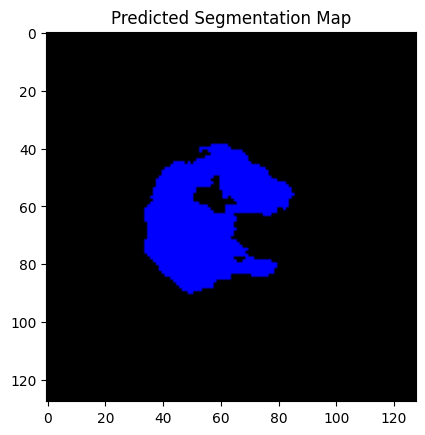

In [45]:
import numpy as np
import matplotlib.pyplot as plt
# 클래스 레이블을 색상 맵으로 변환

# id2label 매핑 (예시)
id2label = {0: 'Background', 1: 'Crushed', 2: 'Breakage', 3: 'Scratched', 4: 'Separated'}

# 클래스 색상 (임의로 지정한 색상)
colors = [
    [0, 0, 0],      # Background
    [255, 0, 0],    # Crushed
    [0, 255, 0],    # Breakage
    [0, 0, 255],    # Scratched
    [255, 255, 0]   # Separated
]

# 예측 맵을 색상으로 변환
colored_map = np.zeros((predictions.shape[0], predictions.shape[1], 3), dtype=np.uint8)

for class_id, color in enumerate(colors):
    colored_map[predictions == class_id] = color

# 예측된 세그멘테이션 맵을 시각화
plt.imshow(colored_map)
plt.title("Predicted Segmentation Map")
plt.show()

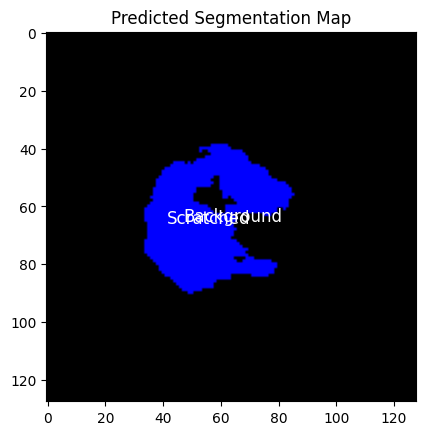

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# 클래스 레이블을 색상 맵으로 변환
id2label = {0: 'Background', 1: 'Crushed', 2: 'Breakage', 3: 'Scratched', 4: 'Separated'}

# 클래스 색상 (임의로 지정한 색상)
colors = [
    [0, 0, 0],      # Background
    [255, 0, 0],    # Crushed
    [0, 255, 0],    # Breakage
    [0, 0, 255],    # Scratched
    [255, 255, 0]   # Separated
]

# 예측 맵을 색상으로 변환
colored_map = np.zeros((predictions.shape[0], predictions.shape[1], 3), dtype=np.uint8)

for class_id, color in enumerate(colors):
    colored_map[predictions == class_id] = color

# 예측된 세그멘테이션 맵을 시각화
plt.imshow(colored_map)
plt.title("Predicted Segmentation Map")

# 손상 종류 텍스트 추가
for class_id, label in id2label.items():
    # 클래스 위치를 계산하기 위해 예측된 각 클래스의 좌표를 구함
    class_mask = predictions == class_id
    if np.any(class_mask.cpu().numpy()):  # 해당 클래스가 존재하는 경우
        # 텍스트의 위치 (클래스 영역의 중앙에 텍스트 배치)
        y, x = np.where(class_mask.cpu().numpy())
        text_position = (np.mean(y), np.mean(x))

        # 손상 종류 텍스트 추가
        plt.text(text_position[1], text_position[0], label, color='white', fontsize=12, ha='center', va='center')

# 결과 시각화
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
